In [1]:
from gwpy.timeseries import TimeSeries
from etc import config
import nds2
from scipy.signal import coherence
import matplotlib.pyplot as plt

In [2]:
def fetch_timeseries_data(channel, gps_start, gps_end):
    data = TimeSeries.fetch(channel, gps_start, gps_end, allow_tape=True)
    # any preprocessing if desired goes here
    return data


def coherence_calculator(data_A, data_B):
    rate = data_A.sample_rate.value
    f,coh = coherence(data_A.value,data_B.value, fs=rate, nperseg=rate*512, noverlap=rate*512/2)
    return f,coh


def plot_asd_coherence(data_A, data_B):

    f,coh = coherence_calculator(data_A, data_B)
    ax1 = plt.subplot(211)
    asd_a = ITMX_data.asd(fftlength=512,overlap=0.5)
    asd_b = ITMY_data.asd(fftlength=512,overlap=0.5)
    ax1.plot(asd_a.frequencies, asd_a.value, label="ITMX")
    ax1.plot(asd_b.frequencies, asd_b.value, label="ITMY")
    ax1.set_xlim(0.001,100)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax2 = plt.subplot(212,sharex=ax1)
    ax2.plot(f,coh)
    plt.show()

In [3]:
# Checking coherence between ETMX and ITMX ground sensors

ITMX_data = fetch_timeseries_data('L1:ISI-GND_STS_ITMX_X_DQ',
                                  1391545000, 1391545000 + 26*512 )
ITMY_data = fetch_timeseries_data('L1:ISI-GND_STS_ITMY_X_DQ',
                                  1391545000, 1391545000 + 26*512 )

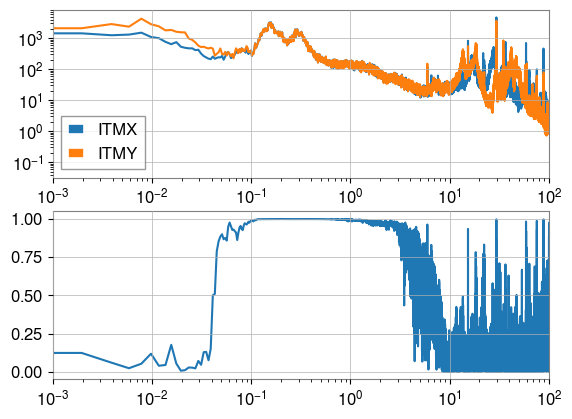

In [4]:
plot_asd_coherence(ITMX_data, ITMY_data)

In [5]:
f,coh = coherence_calculator(ITMX_data, ITMY_data)

In [7]:
import numpy as np
rounded_coh = np.round(coh, 2)


In [30]:
first_one_coh = np.min(np.where(rounded_coh == 1.00))
corresponding_f = f[40]

print(corresponding_f, first_one_coh)

0.078125 56


In [38]:
check_array = np.arange(first_one_coh,0, -10)

In [39]:
for i in range(len(check_array)):
    try:
        sub_array = rounded_coh[check_array[i+1]:check_array[i]]
        min_sub_array = np.min(sub_array)
        max_sub_array = np.max(sub_array)
        diff = max_sub_array - min_sub_array
        if diff >0.5:
            print(min_sub_array)
            print(np.where(sub_array == min_sub_array)[0])
            print(np.arange(check_array[i+1],check_array[i]))
            print(rounded_coh[16])
            print(f[16])
            break
                
    except:
        print("reached the end")

0.05
[0]
[16 17 18 19 20 21 22 23 24 25]
0.05
0.03125
